# Recommender System - 기본 과제 #3

## 개요

1. Factorization Machine(FM)을 PyTorch로 구현해본다.
2. Field-aware Factorization Machine(FFM)을 PyTorch로 구현해본다.

- 과제는 **<font color=#5F71F7>과제 HOMEWORK</font>** 라는 키워드로 표시하였습니다.
- <code><font color=#007979># FILL HERE : ... #</font></code>라고 쓰여 있는 부분을 채워넣으시면 됩니다.

---

## 0. 전처리

### 0.1. 기본 설정

In [ ]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
###############################################################################
# 주어진 결과와 정확히 비교하기 위한 random seed 고정
###############################################################################

seed = 0  # 바꾸지 마시오!
random.seed(seed)
np.random.seed(seed)

### 0.2. MovieLens 데이터셋 불러오기


#### 활용 데이터셋 : MovieLens 100k Dataset

- 출처 :
    <br>Harper, F. M., & Konstan, J. A. (2015). **The MovieLens Datasets: History and Context.** ACM Transactions on Interactive Intelligent Systems (TIIS), 5(4), 1-19. http://dx.doi.org/10.1145/2827872
    
    
- 본 데이터셋은 직접 GroupLens 측을 통해 Naver Boostcamp RecSys 강좌 내에서 활용 및 재배포를 허가받은 데이터셋입니다.
    <br> 과제 외의 목적으로 이용하고자 할 경우 [원시 데이터](https://grouplens.org/datasets/movielens/)를 직접 다운받아 사용하시기 바랍니다.
    <br> ( 각 데이터셋에 대한 README.txt 파일을 통해 라이센스 정보를 확인하실 수 있습니다. )
    
  

In [ ]:
base_path = os.path.join(os.curdir, 'data/')
data_path = os.path.join(base_path, 'ml-100k/')

In [ ]:
# 평점 데이터
ratings_df = pd.read_csv(data_path + 'u.data', sep='\t', encoding='latin-1', header=None)
ratings_df.columns = ['user_id', 'movie_id', 'rating', 'timestamp']

# 영화 데이터
movies_df = pd.read_csv(data_path + 'u.item', sep='|', encoding='latin-1', header=None)
movies_df.columns = ['movie_id', 'movie_title', 'release_date', 'video_release_date',
                     'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 
                     'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                     'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
                     'Thriller', 'War', 'Western'] 

# 유저 데이터
users_df = pd.read_csv(data_path + 'u.user', sep='|', encoding='latin-1', header=None)
users_df.columns = ['user_id', 'age', 'gender', 'occupation', 'zip_code']

### 0.3. 나이를 수치형 변수에서 카테고리형 변수(10대, 20대, ...)로 분류하기

In [ ]:
def age_map(x):
    x = int(x)
    if x < 20:
        return '10'
    elif x >= 20 and x < 30:
        return '20'
    elif x >= 30 and x < 40:
        return '30'
    elif x >= 40 and x < 50:
        return '40'
    elif x >= 50 and x < 60:
        return '50'
    else:
        return '60'

In [ ]:
users_df['age'] = users_df['age'].apply(lambda x: age_map(x))

### 0.4. 유저 피쳐와 영화 피쳐를 평점 dataframe에 조인하기

- 사용할 유저 피쳐: <br> `['user_id', 'age', 'gender']`
<br>

- 사용할 아이템 피쳐: <br> `['movie_id', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']`

In [ ]:
df = pd.merge(ratings_df, movies_df, how='left', on ='movie_id')
df = pd.merge(df, users_df, how='left', on='user_id')

df = df[['user_id', 'age', 'gender',
         'movie_id', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 
         'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 
         'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western',
         'rating']]

df

,user_id,age,gender,movie_id,unknown,Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating
0,196,40,M,242,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3
1,186,30,F,302,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,3
2,22,20,M,377,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
3,244,20,M,51,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,2
4,166,40,M,346,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,880,10,M,476,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3
99996,716,30,F,204,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,5
99997,276,20,M,1090,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
99998,13,40,M,225,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,2


### 0.5. CTR 예측 데이터로 변환하기

- CTR 예측 데이터는 아이템이 노출되었지만 유저가 클릭하지 않았을 때 0, 클릭했을 때 1의 라벨을 가집니다.
- 이와 유사한 형태로 MovieLens 데이터셋을 CTR 예측 데이터로 사용하기 위해 아래와 같이 `rating` 변수의 값을 변환합니다.
    - 5점 만점에 4점 이상 : 1
    - 5점 만점에 4점 미만 : 0

In [ ]:
df.rating = [int(i/4) for i in df.rating]
df.rating = df.rating

df

,user_id,age,gender,movie_id,unknown,Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating
0,196,40,M,242,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,186,30,F,302,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0
2,22,20,M,377,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,244,20,M,51,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
4,166,40,M,346,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,880,10,M,476,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
99996,716,30,F,204,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1
99997,276,20,M,1090,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
99998,13,40,M,225,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


### 0.6. FM 모델에 사용하기 위해 카테고리형 변수 One-hot Encoding 하기

In [ ]:
# 정수값이라 카테고리형 변수로 인식되지 않는 user_id, movie_id의 타입을 명시적으로 변환
df['user_id'] = df['user_id'].astype("category")
df['movie_id'] = df['movie_id'].astype("category")

In [ ]:
# one-hot encoding
fm_df = pd.get_dummies(df)
fm_df

,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,movie_id_1673,movie_id_1674,movie_id_1675,movie_id_1676,movie_id_1677,movie_id_1678,movie_id_1679,movie_id_1680,movie_id_1681,movie_id_1682
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99996,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99998,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
print('***** features in fm_df *****')
print(*fm_df.columns[:25], '...', *fm_df.columns[-25:], sep='\t')

***** features in fm_df *****
unknown	Action	Adventure	Animation	Children	Comedy	Crime	Documentary	Drama	Fantasy	Film-Noir	Horror	Musical	Mystery	Romance	Sci-Fi	Thriller	War	Western	rating	user_id_1	user_id_2	user_id_3	user_id_4	user_id_5	...	movie_id_1658	movie_id_1659	movie_id_1660	movie_id_1661	movie_id_1662	movie_id_1663	movie_id_1664	movie_id_1665	movie_id_1666	movie_id_1667	movie_id_1668	movie_id_1669	movie_id_1670	movie_id_1671	movie_id_1672	movie_id_1673	movie_id_1674	movie_id_1675	movie_id_1676	movie_id_1677	movie_id_1678	movie_id_1679	movie_id_1680	movie_id_1681	movie_id_1682


### 0.7. FFM 모델에 사용할 데이터셋 만들기

In [ ]:
genre_list = ['unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 
              'Documentary', 'Drama','Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 
              'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

ffm_df = df[['rating', 'user_id', 'age', 'gender', 'movie_id']].copy()
ffm_df['genre'] = np.argmax(np.asarray(df[genre_list]), axis=1)

In [ ]:
col_dict = dict()

for col in ffm_df.columns:
    if col == 'rating': continue
    ffm_df[col] = ffm_df[col].astype("category")
    col_dict[col] = {value: idx for idx, value in enumerate(ffm_df[col].cat.categories)}
    ffm_df[col] = ffm_df[col].cat.codes

ffm_df

,rating,user_id,age,gender,movie_id,genre
0,0,195,3,1,241,5
1,0,185,2,0,301,6
2,0,21,1,1,376,4
3,0,243,1,1,50,8
4,0,165,3,1,345,6
...,...,...,...,...,...,...
99995,0,879,0,1,475,5
99996,1,715,2,0,203,5
99997,0,275,1,1,1089,16
99998,0,12,3,1,224,4


In [ ]:
# FM 데이터셋과 FFM 데이터셋의 입력값 차원이 동일한지 확인
assert sum(list(len(col_dict[k]) for k in col_dict)) == fm_df.shape[1] - 1

### 0.8. 전체 데이터셋 8:2로 분리하여 학습 및 테스트 데이터셋으로 사용

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(
    fm_df.loc[:, fm_df.columns != 'rating'], fm_df['rating'], test_size=0.2, random_state=seed)
print('학습 데이터 크기:', train_X.shape, train_y.shape)
print('테스트 데이터 크기:', test_X.shape, test_y.shape)

학습 데이터 크기: (80000, 2652) (80000,)
테스트 데이터 크기: (20000, 2652) (20000,)


In [ ]:
# PyTorch의 DataLoader에서 사용할 수 있도록 변환 
train_dataset_fm = TensorDataset(torch.Tensor(np.array(train_X)), torch.Tensor(np.array(train_y)))
test_dataset_fm = TensorDataset(torch.Tensor(np.array(test_X)), torch.Tensor(np.array(test_y)))

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(
    ffm_df.loc[:, ffm_df.columns != 'rating'], ffm_df['rating'], test_size=0.2, random_state=seed)
print('학습 데이터 크기:', train_X.shape, train_y.shape)
print('테스트 데이터 크기:', test_X.shape, test_y.shape)

학습 데이터 크기: (80000, 5) (80000,)
테스트 데이터 크기: (20000, 5) (20000,)


In [ ]:
# PyTorch의 DataLoader에서 사용할 수 있도록 변환 
train_dataset_ffm = TensorDataset(torch.LongTensor(np.array(train_X)), torch.Tensor(np.array(train_y)))
test_dataset_ffm = TensorDataset(torch.LongTensor(np.array(test_X)), torch.Tensor(np.array(test_y)))

In [ ]:
del df, train_X, train_y, test_X, test_y

---

## 1. PyTorch로 FM 구현하기

- FM Formula ~ $O(kn^2)$
$$\hat{y}\left(\mathrm{x}\right) = w_0 + \sum_{i=1}^{n}{\mathrm{w}_i x_i} + \sum_{i=1}^{n} \sum_{j=i+1}^{n}{\left \langle \mathrm{v}_i , \mathrm{v}_j  \right \rangle x_i x_j}$$


- Revised Formula ~ $O(kn)$
$$\hat{y}\left(\mathrm{x}\right)= w_0 + \sum_{i=1}^{n}{\mathrm{w}_i x_i} + \frac{1}{2} \sum_{f=1}^{k} \left( \left( \sum_{i=1}^{n} v_{i,f} x_i \right)^2 - \sum_{i=1}^{n} v_{i,f}^2 x_i^2 \right)$$

    ( 8강 강의자료 49페이지 참조 )
$$\because \sum_{i=1}^{n} \sum_{j=i+1}^{n}{\left \langle \mathrm{v}_i , \mathrm{v}_j  \right \rangle x_i x_j} = \frac{1}{2} \sum_{f=1}^{k} \left( \left( \sum_{i=1}^{n} v_{i,f} x_i \right)^2 - \sum_{i=1}^{n} v_{i,f}^2 x_i^2 \right)$$


### <font color='#5F71F7'>과제 HOMEWORK (1)</font> 
### 1.1. `FMLayer` 클래스 구현하기


- `FMLayer`에서 구현할 부분 :
$$\mathrm{FMLayer}\left( \mathrm{x} \right) = \frac{1}{2} \sum_{f=1}^{k} \left[ \left( \sum_{i=1}^{n} v_{i,f} x_i \right)^2 - \sum_{i=1}^{n} v_{i,f}^2 x_i^2 \right]$$

- <font color=blue>힌트)</font>
    <br> 배치 사이즈가 b일 때, $X$와 $V$ 행렬은 아래와 같이 정의된다.

$$X = \begin{bmatrix} x_{1,1} & \dots & x_{1,n}\\ \vdots \ & \ddots \ & \vdots \\ x_{b,1} & \dots & x_{b,n} \\ \end{bmatrix} , \quad V = \begin{bmatrix} v_{1,1} & \dots & v_{1,k}\\ \vdots \ & \ddots \ & \vdots \\ v_{n,1} & \dots & v_{n,k} \\ \end{bmatrix} $$
    
- 두 행렬을 곱하면 아래와 같이 표현된다.

$$XV = \begin{bmatrix} \sum_{i=1}^{n} v_{i,1} x_{1,i}  & \dots &  \sum_{i=1}^{n} v_{i,k} x_{1,i} \\ \vdots \ & \ddots \ & \vdots \\ \sum_{i=1}^{n} v_{i,1} x_{1,b}  & \dots & \sum_{i=1}^{n} v_{i,k} x_{1,b}  \\ \end{bmatrix}$$
    
- 따라서, <code>FMLayer</code>의 수식이 아래와 같이 표현됨을 알 수 있다.

$$\mathrm{FMLayer}\left( X \right)  = \frac{1}{2} \sum \left[ \, \mathrm{square} \left( XV \right) \, - \, \left( \, \mathrm{square} \left( X \right) \times \mathrm{square} \left(V \right) \, \right) \, \right]$$

In [ ]:
class FMLayer(nn.Module):
    def __init__(self, input_dim, factor_dim):
        '''
        Parameter
            input_dim: Input dimension in sparse representation (2652 in MovieLens-100k)
            factor_dim: Factorization dimension
        '''
        super(FMLayer, self).__init__()
        self.v = nn.Parameter(
            torch.empty(input_dim, factor_dim)  # FILL HERE : Fill in the places `None` #
            , requires_grad = True
        )
        
    def square(self, x):
        return torch.pow(x,2)

    def forward(self, x):
        '''
        Parameter
            x: Float tensor of size "(batch_size, input_dim)"
        '''
        square_of_sum = self.square(torch.matmul(x, self.v)) # FILL HERE : Use `torch.matmul()` and `self.square()` #
        sum_of_square = torch.matmul(self.square(x), self.square(self.v)) # FILL HERE : Use `torch.matmul()` and `self.square()` #
        
        return 0.5 * torch.sum(square_of_sum - sum_of_square, dim=1)

### <font color='#5F71F7'>과제 HOMEWORK (2)</font> 
### 1.2. `FMLayer`를 이용해 `FactorizationMachine` 모델 구현하기

- `FactorizationMachine`에서 구현할 부분 :

$$\hat{y}(\mathrm{x}) = w_0 + \sum_{i=1}^{n}{\mathrm{w}_i x_i} + \mathrm{FMLayer}\left( \mathrm{x} \right) \\ \, = \mathrm{Linear}\left( \mathrm{x} \right) + \mathrm{FMLayer}\left( \mathrm{x} \right)$$


In [ ]:
class FactorizationMachine(nn.Module):
    def __init__(self, input_dim, factor_dim):
        '''
        Parameter
            input_dim: Input dimension in sparse representation (2652 in MovieLens-100k)
            factor_dim: Factorization dimension
        '''
        super(FactorizationMachine, self).__init__()
        
        self.linear = nn.Linear(input_dim, 1, bias=True) # FILL HERE : Fill in the places `None` #
        self.fm = FMLayer(input_dim, factor_dim) # FILL HERE : Fill in the places `None` #
        
        self._initialize_weights()
        
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, FMLayer):
                nn.init.normal_(m.v, 0, 0.01)
                
        
    def forward(self, x):
        '''
        Parameter
            x: Long tensor of size "(batch_size, input_dim)"
        
        Return
            y: Float tensor of size "(batch_size)"
        '''
        y = self.linear(x).squeeze(1) + self.fm(x) # FILL HERE : Use `self.linear()` and `self.fm()` #
        
        return y

### 1.3. FM 모델 학습하기

- `task = 'reg'` : 회귀 문제
    - 학습 : MSE를 손실함수로 사용
    - 검증 : MAE 사용


- `task = 'clf'` : 이진 분류 문제
    - 학습 : Cross Entropy를 손실 함수로 사용 ( 모델의 리턴 값이 logit이므로 `nn.BCEWithLogitsLoss()`를 사용 )
    - 검증 : AUC 사용
    <br>

#### 1.3.1. 학습 및 테스트에 필요한 함수 작성

In [ ]:
# Reference - https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    train_loss /= num_batches
    
    return train_loss


def test_loop(dataloader, model, loss_fn, task):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, y_all, pred_all = 0, list(), list()

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item() / num_batches
            y_all.append(y)
            pred_all.append(pred)
    
    y_all = torch.cat(y_all)
    pred_all = torch.cat(pred_all)
    
    if task == 'reg':
        err = abs(pred_all - y_all).type(torch.float).mean().item()
        print(f"Test Error: \n  MAE: {(err):>8f} \n  Avg loss: {test_loss:>8f}")
    else:
        err = roc_auc_score(y_all, torch.sigmoid(pred_all)).item()
        print(f"Test Error: \n  AUC: {err:>8f} \n  Avg loss: {test_loss:>8f}")
    
    return err, test_loss

In [ ]:
def train_and_test(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs, task):
    train_loss, test_err, test_loss = list(), list(), list()
    
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss.append(train_loop(train_dataloader, model, loss_fn, optimizer))
        test_result = test_loop(test_dataloader, model, loss_fn, task)
        test_err.append(test_result[0])
        test_loss.append(test_result[1])
        print("-------------------------------\n")
    print("Done!")
    
    return train_loss, test_err, test_loss

#### 1.3.2. 하이퍼파라미터 설정 & 학습에 필요한 인스턴스 선언 및 초기화

In [ ]:
######## Hyperparameter ########

input_dim = fm_df.shape[1] - 1
batch_size = 256
data_shuffle = True
task = 'clf'
factorization_dim = 8
epochs = 20
learning_rate = 0.001
gpu_idx = 0

################################
# torch.cuda.empty_cache() # if necessary
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

device = torch.device("cuda:{}".format(gpu_idx) if torch.cuda.is_available() else "cpu")
print(device)

train_dataloader_fm = DataLoader(train_dataset_fm, batch_size=batch_size, shuffle=data_shuffle)
test_dataloader_fm = DataLoader(test_dataset_fm, batch_size=batch_size, shuffle=data_shuffle)

model = FactorizationMachine(input_dim, factorization_dim).to(device)

loss_fn = nn.MSELoss().to(device) if (task == 'reg') else nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)

cpu


#### 1.3.3. 학습 진행

In [ ]:
train_loss, test_err, test_loss = train_and_test(train_dataloader_fm, test_dataloader_fm, 
                                                 model, loss_fn, optimizer, epochs, task)

Epoch 1
-------------------------------
loss: 0.695116  [    0/80000]
loss: 0.649317  [25600/80000]
loss: 0.607862  [51200/80000]
loss: 0.603815  [76800/80000]
Test Error: 
  AUC: 0.749980 
  Avg loss: 0.604876
-------------------------------

Epoch 2
-------------------------------
loss: 0.584004  [    0/80000]
loss: 0.564439  [25600/80000]
loss: 0.595235  [51200/80000]
loss: 0.518740  [76800/80000]
Test Error: 
  AUC: 0.767400 
  Avg loss: 0.574228
-------------------------------

Epoch 3
-------------------------------
loss: 0.541213  [    0/80000]
loss: 0.559245  [25600/80000]
loss: 0.502169  [51200/80000]
loss: 0.515163  [76800/80000]
Test Error: 
  AUC: 0.772699 
  Avg loss: 0.566166
-------------------------------

Epoch 4
-------------------------------
loss: 0.570050  [    0/80000]
loss: 0.559718  [25600/80000]
loss: 0.527368  [51200/80000]
loss: 0.583159  [76800/80000]
Test Error: 
  AUC: 0.773924 
  Avg loss: 0.565763
-------------------------------

Epoch 5
----------------

#### 1.3.4. 학습 곡선 도식화

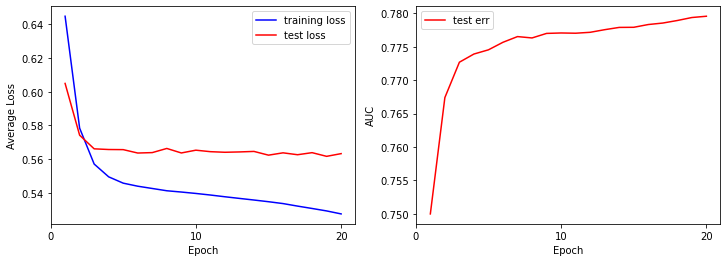

In [ ]:
fig, (loss_ax, err_ax) = plt.subplots(1,2, figsize=(12,4))

loss_ax.plot(range(1,epochs+1), train_loss, 'b', label='training loss')
loss_ax.plot(range(1,epochs+1), test_loss, 'r', label='test loss')
err_ax.plot(range(1,epochs+1), test_err, 'r', label='test err')

loss_ax.set_xticks(range(0, epochs+1, 10))
loss_ax.set_xlabel('Epoch')
loss_ax.set_ylabel('Average Loss')
loss_ax.legend()

err_ax.set_xticks(range(0, epochs+1, 10))
err_ax.set_xlabel('Epoch')
err_ax.set_ylabel('AUC')
err_ax.legend()

plt.show()

---

## 2. PyTorch로 FFM 구현하기

### <font color='#5F71F7'>과제 HOMEWORK (3)</font> 
### 2.1. `FFMLayer` 구현하기

- `FFMLayer`에서 구현할 부분 :

$$ \mathrm{FFMLayer} \left( \mathrm{x} \right) = \sum_{i=1}^{n} \sum_{j=i+1}^{n}{\left \langle \mathrm{v}_{i,f_j} \, , \mathrm{v}_{j,f_i} \right \rangle x_i x_j} \\ \qquad \qquad \quad = \sum_{i=1}^{n} \sum_{j=i+1}^{n}{\left \langle x_i \mathrm{v}_{i,f_j} \, , x_j \mathrm{v}_{j,f_i} \right \rangle}$$

- <font color=blue>참고 1)</font>
    <br> 수식은 입력값($x$)을 중심으로 전개되어 있지만, 이를 필드($f$) 중심으로 전개하면 아래와 같다. (필드의 총 개수: $F$)

$$\sum_{i=1}^{n} \sum_{j=i+1}^{n}{\left \langle x_i \mathrm{v}_{i,f_j} , x_j \mathrm{v}_{j,f_i}  \right \rangle} = \sum_{f=1}^{F} \sum_{g=i+1}^{F}{\left \langle x_{i_g} \mathrm{v}_{i_g,f} \, , x_{i_f} \mathrm{v}_{i_f,g}  \right \rangle}$$

- <font color=blue>참고 2)</font>
    <br> $x_i \mathrm{v}_{i,f}$는 필드 $f$에 대해 $x_{i}$를 $k$개의 factorization 차원으로 임베딩한 것으로 이해할 수 있다.
    <br> 따라서, `nn.Embedding()`을 통해 내적 안에 사용될 값을 쉽게 계산할 수 있다.
    <br>

- <font color=red>주의)</font>
    <br> `forward()` 함수에 들어가는 입력값 `x`의 형태:
    - [3,1,0,6] $\Rightarrow$ (X)
    - [0,0,0,1, 0,1, 1,0,0, 0,0,0,0,0,0,1,0,0] $\Rightarrow$ (X)
    - [3,5,6,15] $\Rightarrow$ (O)
        - `FieldAwareFM` 모델에서 이미 변환되므로 `FFMLayer`에서는 이를 가정하고 코딩해야 함
    <br>
    

In [ ]:
class FFMLayer(nn.Module):
    def __init__(self, field_dims, factor_dim):
        '''
        Parameter
            field_dims: List of field dimensions 
                        The sum become the entire dimension of input (in sparse feature)
                        The length become the number of fields
            factor_dim: Factorization dimension
        '''
        super().__init__()
        self.num_fields = len(field_dims)
        self.input_dim = sum(field_dims)
        self.embedding = nn.ModuleList([
            # FILL HERE : Fill in the places `None` with                                      #
            #             either `factorization_dim`, `self.num_fields`, or `self.input_dim`. #
            nn.Embedding(
                self.input_dim, factor_dim
            ) for _ in range(self.num_fields)
        ])

    def forward(self, x):
        '''
        Parameter
            x: Long tensor of size "(batch_size, num_fields)"
               Each value of variable is an index calculated including the dimensions up to the previous variable.
               for instance, [gender:male, age:20, is_student:True] 
                             -> [1,0, 0,1,0,0,0,0, 0,1] in one-hot encoding
                             -> x = [0,3,9].
        Return
            y: Float tensor of size "(batch_size)"
        '''
        
        xv = [self.embedding[f](x) for f in range(self.num_fields)]
        
        y = list()
        for f in range(self.num_fields):
            for g in range(f + 1, self.num_fields):
                y.append(xv[f][:, g] *  xv[g][:, f])
        y = torch.stack(y, dim=1)
        
        return torch.sum(y, dim=(2,1))

### <font color='#5F71F7'>과제 HOMEWORK (4)</font> 
### 2.2. `FFMLayer`를 활용하여 `FieldAwareFM` 모델 구현하기

- `FieldAwareFM`에서 구현할 부분 :
$$\hat{y}(\mathrm{x}) = w_0 + \sum_{i=1}^{n}{\mathrm{w}_i x_i} + \mathrm{FFMLayer}\left( \mathrm{x} \right) \\ \, = \mathrm{Linear}\left( \mathrm{x} \right) + \mathrm{FFMLayer}\left( \mathrm{x} \right)$$
 
        
- <font color=red>주의)</font>
    <br> 각 레이어마다 사용되는 입력값의 형태가 다름
    - `self.linear()` : `x_multihot` 사용 ( ex. [0,0,0,1, 0,1, 1,0,0, 0,0,0,0,0,0,1,0,0] )
    - `self.ffm()` &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; : `x` 사용 ( ex. [3, 5, 6, 15] )
    <br>

In [ ]:

class FieldAwareFM(nn.Module):
    def __init__(self, field_dims, factor_dim):
        '''
        Parameter
            field_dims: List of field dimensions
            factor_dim: Factorization dimension
        '''
        super().__init__()
        self.input_dim = sum(field_dims)
        self.encoding_dims = np.concatenate([[0], np.cumsum(field_dims)[:-1]])
        self.linear = nn.Linear(self.input_dim, 1, bias=True) # FILL HERE : Fill in the places `None` #
        self.ffm = FFMLayer(field_dims, factor_dim) # FILL HERE : Fill in the places `None` #
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Embedding):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, FFMLayer):
                nn.init.normal_(m.v, 0, 0.01)

    def forward(self, x):
        '''
        Parameter
            x: Long tensor of size "(batch_size, num_fields)"
                x_multihot: Multi-hot coding of x. size "(batch_size, self.input_dim)"
        
        Return
            y: Float tensor of size "(batch_size)"
        '''
        
        x = x + x.new_tensor(self.encoding_dims).unsqueeze(0)
        x_multihot = torch.zeros(x.size(0), self.input_dim).scatter_(1, x, 1.)
        
        y = self.linear(x_multihot).squeeze(1) + self.ffm(x) # FILL HERE : Use `self.linear()` and `self.ffm()` #

        return y
        

### 2.3. FFM 모델 학습하기

- `task = 'reg'` : 회귀 문제
    - 학습 : MSE를 손실함수로 사용
    - 검증 : MAE 사용


- `task = 'clf'` : 이진 분류 문제
    - 학습 : Cross Entropy를 손실 함수로 사용 ( 모델의 리턴 값이 logit이므로 `nn.BCEWithLogitsLoss()`를 사용 )
    - 검증 : AUC 사용


- 1.3.에서 선언한 `train_and_test()` 함수 그대로 사용

#### 2.3.1. 하이퍼파라미터 설정 & 학습에 필요한 인스턴스 선언 및 초기화

In [ ]:
######## Hyperparameter ########

batch_size = 256
data_shuffle = True
task = 'clf'
factorization_dim = 8
epochs = 20
learning_rate = 0.001
gpu_idx = 0

################################
# torch.cuda.empty_cache() # if necessary
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

device = torch.device("cuda:{}".format(gpu_idx) if torch.cuda.is_available() else "cpu")

train_dataloader_ffm = DataLoader(train_dataset_ffm, batch_size=batch_size, shuffle=data_shuffle)
test_dataloader_ffm = DataLoader(test_dataset_ffm, batch_size=batch_size, shuffle=data_shuffle)

field_dims = list(len(col_dict[k]) for k in col_dict)
model = FieldAwareFM(field_dims, factorization_dim).to(device)

loss_fn = nn.MSELoss().to(device) if (task == 'reg') else nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001, amsgrad=True)

#### 2.3.2. 학습 진행

In [ ]:
train_loss, test_err, test_loss = train_and_test(train_dataloader_ffm, test_dataloader_ffm, 
                                                 model, loss_fn, optimizer, epochs, task)

Epoch 1
-------------------------------
loss: 3.251076  [    0/80000]
loss: 2.919937  [25600/80000]
loss: 2.234608  [51200/80000]
loss: 2.196770  [76800/80000]
Test Error: 
  AUC: 0.544755 
  Avg loss: 2.090629
-------------------------------

Epoch 2
-------------------------------
loss: 2.164351  [    0/80000]
loss: 1.691077  [25600/80000]
loss: 1.697688  [51200/80000]
loss: 1.387013  [76800/80000]
Test Error: 
  AUC: 0.577898 
  Avg loss: 1.407961
-------------------------------

Epoch 3
-------------------------------
loss: 1.271713  [    0/80000]
loss: 1.252679  [25600/80000]
loss: 1.154112  [51200/80000]
loss: 0.906826  [76800/80000]
Test Error: 
  AUC: 0.611232 
  Avg loss: 1.028819
-------------------------------

Epoch 4
-------------------------------
loss: 0.987868  [    0/80000]
loss: 0.901243  [25600/80000]
loss: 0.803665  [51200/80000]
loss: 0.722214  [76800/80000]
Test Error: 
  AUC: 0.643080 
  Avg loss: 0.814572
-------------------------------

Epoch 5
----------------

#### 2.3.3. 학습 곡선 도식화

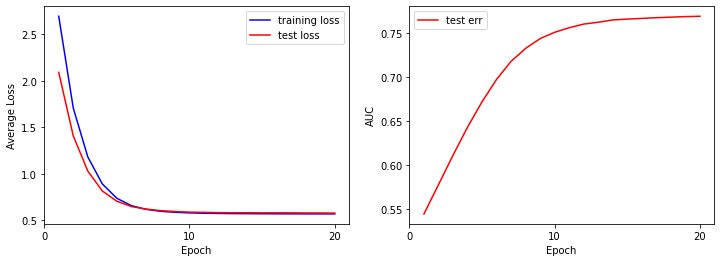

In [ ]:
fig, (loss_ax, err_ax) = plt.subplots(1,2, figsize=(12,4))

loss_ax.plot(range(1,epochs+1), train_loss, 'b', label='training loss')
loss_ax.plot(range(1,epochs+1), test_loss, 'r', label='test loss')
err_ax.plot(range(1,epochs+1), test_err, 'r', label='test err')

loss_ax.set_xticks(range(0, epochs+1, 10))
loss_ax.set_xlabel('Epoch')
loss_ax.set_ylabel('Average Loss')
loss_ax.legend()

err_ax.set_xticks(range(0, epochs+1, 10))
err_ax.set_xlabel('Epoch')
err_ax.set_ylabel('AUC')
err_ax.legend()

plt.show()